In [2]:
%load_ext autoreload
%autoreload 2

import os
import glob
import pyvista as pv
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import torch

from natsort import natsorted
from skimage import io
from scipy.ndimage import distance_transform_edt
from pore_net.utils import down_sample
from pore_net.triplane.model import TriplaneAutoDecoder, MultiTriplane



device = 'cuda' if torch.cuda.is_available() else 'cpu'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Explore tri-plane - validation/test set

In [3]:
# Original path
# model_pth = "/gpfs/home/cw1722/particle/pore_net/out/triplane_06_10_13_52_num_points_500000_lr_0.001/model_epoch_55_loss_0.22771792113780975.pt"
# model_pth = "/Users/chunyang/Downloads/model_epoch_65_loss_0.26348745822906494.pt"

# Refitted for test set
# model_pth = "/gpfs/home/cw1722/particle/pore_net/out/triplane_06_14_22_34_num_points_500000_lr_0.001_ds8/triplane_150_200.pt"
# model_pth = "/Users/chunyang/Downloads/triplane_0_10_exp_72.pt"
model_pth = "/Users/chunyang/Downloads/triplane_0_10_exp_72 (1).pt"
# model_pth = "/Users/chunyang/Downloads/triplane_150_151.pt"
auto_decoder = MultiTriplane(
        num_objs=10,
        input_dim=3,
        output_dim=1,
        device=device)
# checkpoint = torch.load(model_pth)
checkpoint = torch.load(model_pth, map_location=torch.device(device))
print(checkpoint.keys())
auto_decoder.load_state_dict(checkpoint)


Initializing MultiTriplane Model:
Number of Objects:        10
Resolution:               128
Number of Channels:       32
Device:                   cpu
Noise Value:              None
Total Parameters:         15,763,841

Parameter Distribution:
Triplane Parameters:      15,728,640
Decoder Parameters:       35,201

odict_keys(['embeddings.0', 'embeddings.1', 'embeddings.2', 'embeddings.3', 'embeddings.4', 'embeddings.5', 'embeddings.6', 'embeddings.7', 'embeddings.8', 'embeddings.9', 'embeddings.10', 'embeddings.11', 'embeddings.12', 'embeddings.13', 'embeddings.14', 'embeddings.15', 'embeddings.16', 'embeddings.17', 'embeddings.18', 'embeddings.19', 'embeddings.20', 'embeddings.21', 'embeddings.22', 'embeddings.23', 'embeddings.24', 'embeddings.25', 'embeddings.26', 'embeddings.27', 'embeddings.28', 'embeddings.29', 'net.0._B', 'net.1.weight', 'net.1.bias', 'net.3.weight', 'net.3.bias', 'net.5.weight', 'net.5.bias'])


<All keys matched successfully>

In [4]:
def vis_emb(emb):
    # Sum along channel dimension (dim=1) to get 3 x 128 x 128
    # emb_ = torch.sum(emb, dim=1)
    # emb_ = torch.prod(emb, dim=1)
    # emb_ = emb
    emb_ = [torch.sum(e, dim=0) for e in emb]
    # Create figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot each embedding plane
    for i in range(3):
        im = axes[i].imshow(emb_[i].detach().numpy())
        axes[i].set_title(f'Plane {i}')
        plt.colorbar(im, ax=axes[i])
    
    plt.tight_layout()
    plt.show()

torch.Size([32, 128, 128])
torch.Size([32, 128, 128])
torch.Size([32, 128, 128])


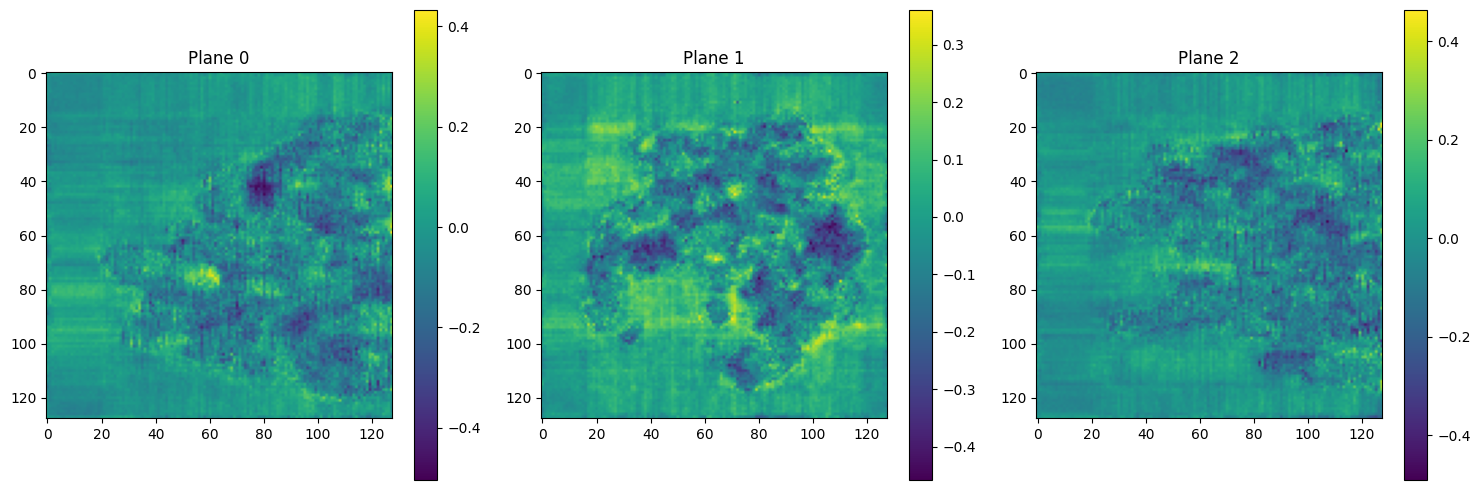

In [5]:
idx = 0
emb_list = auto_decoder.embeddings
emb = [emb_list[idx+i].reshape(32, 128, 128) for i in range(3)]

for i in range(3):
    print(emb[i].shape)

vis_emb(emb)

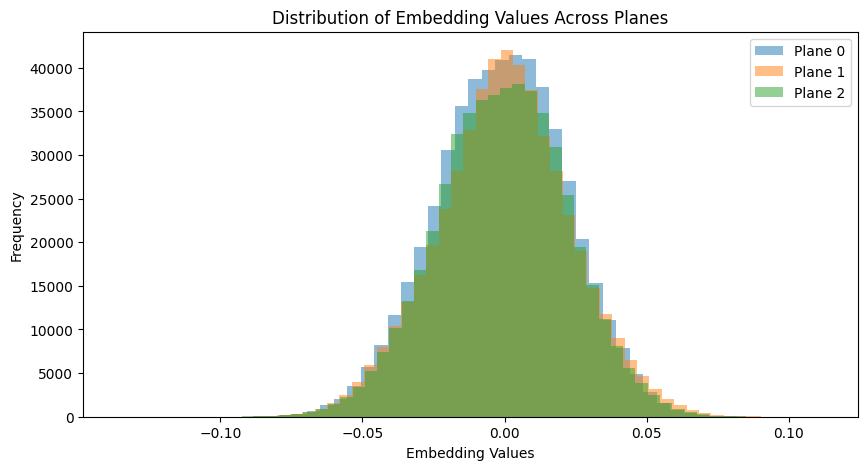

In [20]:
# Flatten each embedding plane and plot histogram
plt.figure(figsize=(10, 5))

for i in range(3):
    flat_emb = emb[i].flatten().detach().numpy()
    plt.hist(flat_emb, bins=50, alpha=0.5, label=f'Plane {i}')

plt.xlabel('Embedding Values')
plt.ylabel('Frequency')
plt.title('Distribution of Embedding Values Across Planes')
plt.legend()
plt.show()


In [6]:
def reconstruct(model, obj_idx, grid_size):
    """
    Reconstruct a 3D object from a 2D embedding using the model.

    Args:
        model: The trained model
        obj_idx: The index of the object to reconstruct
        grid_size: The size of the grid to reconstruct the object on

    Returns:
        A 3D numpy array of the reconstructed object
    """
    res_x, res_y, res_z = grid_size
    x = np.linspace(-1, 1, res_x)
    y = np.linspace(-1, 1, res_y)
    z = np.linspace(-1, 1, res_z)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    coords = np.stack([X, Y, Z], axis=-1)
    coords = torch.from_numpy(coords).float().to(device)
    coords = coords.view(-1, 3)
    coords = coords.unsqueeze(0)  # Add batch dimension [1, N, 3]

    model.eval()
    with torch.no_grad():
        pred = model(obj_idx, coords)
        print(pred.shape)
    pred = pred.view(res_x, res_y, res_z)
    return pred.cpu().numpy()

In [7]:
# Reconstruct the object
grid_size = (89,195,195)
grid = reconstruct(auto_decoder, 0, grid_size)
# grid[grid > 0] = 1
grid[grid < 0] = 0

# Create a plotter and add the grid
plotter = pv.Plotter(notebook=True)
plotter.add_volume(
    grid,
    opacity="linear",
    cmap="jet",
    # clim=[global_min, global_max]
)
plotter.show()


torch.Size([1, 3384225, 1])


Widget(value='<iframe src="http://localhost:59170/index.html?ui=P_0x16b99be80_0&reconnect=auto" class="pyvista…

## Compare the reconstruction performance when down sample factor is 8

In [8]:
from pore_net.utils import down_sample
from skimage import io

In [9]:
def get_dice_score(pred, gt):
    dice_score = (2.0 * (pred * gt).sum()) / (
                    (pred + gt).sum() + 1e-8
                )
    return dice_score

In [10]:
ds_factor = 8
num_samples = 50

tif_dir = "../../../data/Segmentations/072/"
tif_names = natsorted(glob.glob(os.path.join(tif_dir, "*.tif")))
print(len(tif_names))
# Now only use the last 50 frames
tif_names = tif_names
print("number of frames after selection: ", len(tif_names))
print("first 3 frames: ", tif_names[:3])
print("last 3 frames: ", tif_names[-3:])

tif_sample = io.imread(tif_names[0])
tif_sample = down_sample(tif_sample, ds_factor)
sample_shape = tif_sample.shape
print(sample_shape)

100
number of frames after selection:  100
first 3 frames:  ['../../../data/Segmentations/072/072_RobuGlass3_drainage_174nl_min_run4_segmented_0000.tif', '../../../data/Segmentations/072/072_RobuGlass3_drainage_174nl_min_run4_segmented_0001.tif', '../../../data/Segmentations/072/072_RobuGlass3_drainage_174nl_min_run4_segmented_0002.tif']
last 3 frames:  ['../../../data/Segmentations/072/072_RobuGlass3_drainage_174nl_min_run4_segmented_0097.tif', '../../../data/Segmentations/072/072_RobuGlass3_drainage_174nl_min_run4_segmented_0098.tif', '../../../data/Segmentations/072/072_RobuGlass3_drainage_174nl_min_run4_segmented_0099.tif']
(89, 195, 195)


torch.Size([1, 3384225, 1])
Dice score for sample 0: 0.7390199303627014
torch.Size([1, 3384225, 1])
Dice score for sample 1: 0.7365675568580627
torch.Size([1, 3384225, 1])
Dice score for sample 2: 0.7401522397994995
torch.Size([1, 3384225, 1])
Dice score for sample 3: 0.7384859323501587
torch.Size([1, 3384225, 1])
Dice score for sample 4: 0.7413293719291687
torch.Size([1, 3384225, 1])
Dice score for sample 5: 0.739092230796814
torch.Size([1, 3384225, 1])
Dice score for sample 6: 0.7422129511833191
torch.Size([1, 3384225, 1])
Dice score for sample 7: 0.7389205098152161
torch.Size([1, 3384225, 1])
Dice score for sample 8: 0.7382910251617432
torch.Size([1, 3384225, 1])
Dice score for sample 9: 0.7353858947753906
Average dice score: 0.7389457821846008


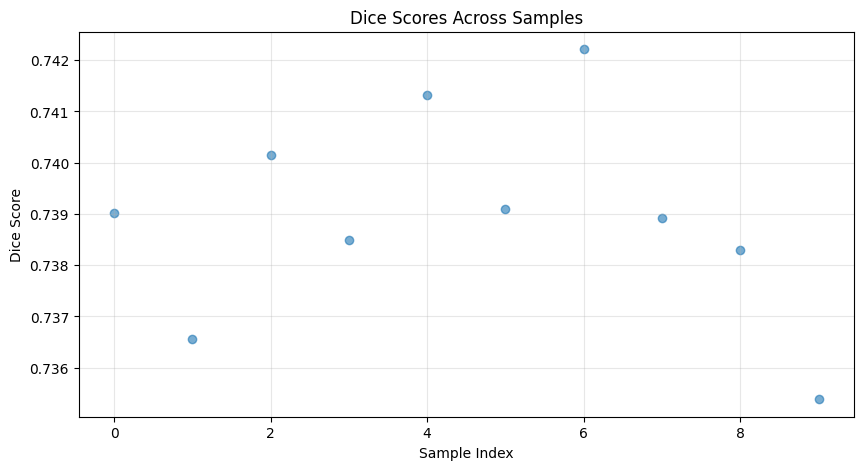

In [16]:
dice_scores = []
for i in range(10):
    tif_sample = io.imread(tif_names[i]) // 255
    tif_sample = down_sample(tif_sample, ds_factor)
    grid_gt = tif_sample.astype(np.float32)
    sample_shape = grid_gt.shape

    grid_pd = reconstruct(auto_decoder, i, sample_shape)
    grid_pd = (grid_pd > 0).astype(np.float32)
    
    dice_score = get_dice_score(grid_pd, grid_gt)
    dice_scores.append(dice_score)
    print(f"Dice score for sample {i}: {dice_score}")

dice_scores = np.array(dice_scores)
print(f"Average dice score: {dice_scores.mean()}")
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(range(len(dice_scores)), dice_scores, alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Dice Score')
plt.title('Dice Scores Across Samples')
plt.grid(True, alpha=0.3)
plt.show()


In [26]:
import pandas as pd

# Create a DataFrame with dice scores
df = pd.DataFrame({
    'sample_index': range(len(dice_scores)),
    'dice_score': dice_scores
})

# Save to CSV
df.to_csv('dice_scores_triplane.csv', index=False)
print("Dice scores saved to dice_scores_072.csv")


Dice scores saved to dice_scores_072.csv


In [11]:
from pore_net.utils import cube2mesh

def cmp_reconstruction(model, obj_idx, target):
    sample_shape = target.shape
    print("Sample shape: ", sample_shape)
    grid_pd = reconstruct(model, obj_idx, sample_shape)
    grid_pd[grid_pd > 0] = 1
    grid_pd[grid_pd < 0] = 0
    grid_pd = (grid_pd > 0).astype(np.float32)
    print("grid_pd.shape: ", grid_pd.shape)
    print("target.shape: ", target.shape)
    dice_score = get_dice_score(grid_pd, target)
    print(f"Dice score for sample {obj_idx}: {dice_score}")

    mesh_gt = cube2mesh(target, threshold=0)
    mesh_pd = cube2mesh(grid_pd, threshold=0)

    p = pv.Plotter(window_size=(1000, 500), shape=(1, 2))
    
    p.subplot(0, 0)
    p.add_mesh(mesh_gt, color='blue')
    p.add_text("Ground Truth", font_size=16)

    p.subplot(0, 1)
    p.add_mesh(mesh_pd, color='red')

    p.add_text("Reconstructed", font_size=16)
    p.add_text(f"Dice score: {dice_score:.4f}", font_size=8,
               position='lower_right')
    p.link_views()
    p.show()
    return dice_score
    

idx = 0
ds_factor = 8
tif_name = tif_names[idx]
tif_sample = io.imread(tif_name) // 255
target = down_sample(tif_sample, ds_factor)

cmp_reconstruction(auto_decoder, idx, target)

Sample shape:  (89, 195, 195)
torch.Size([1, 3384225, 1])
grid_pd.shape:  (89, 195, 195)
target.shape:  (89, 195, 195)
Dice score for sample 0: 0.7602070569992065


Widget(value='<iframe src="http://localhost:59170/index.html?ui=P_0x3277cb520_1&reconnect=auto" class="pyvista…

np.float32(0.76020706)